# Introduction to Neural Networks
### Nerd Club 190417

Jim Bohnslav (with references throughout)

In this introduction, we'll first go over the basic vocabulary of neural networks. We'll follow that up with a 1-neuron, no-hidden-layer neural network, and explain activation functions. We'll extend that to multiple neurons in our layer. We'll finalize making predictions with a one-hidden-layer neural network, which is known as *forward propagation*. Secondly, we'll very briefly go over computation graphs and backpropagation, which are needed to update our parameters. 

By the end of this notebook, you should know the following things:

- [ ] what artificial neural networks are
- [ ] how to make predictions with a neural network and some input (forward propagation)
- [ ] what a loss function is
- [ ] intuitions about how deep learning software estimates gradients (backpropagation)
- [ ] how to update our parameters given our loss and gradients (gradient descent)
- [ ] why you need nonlinearities

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import random
import math

# Introduction and vocabulary

Artificial Neural Networks (**ANNs**) are computing systems loosely modeled after biological brains. Importantly, it has been proven via the [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) that ANNs with 1 hidden layer and nonlinearity can approximate *any* possible function (more on these terms later). 

To start us off, here's a quick guide to the difference between neuroscience and ANN terminology:

| Neuroscience | ANN         |
|--------------|-------------|
| Neuron       | Hidden Unit |
| Firing Rate  | Activation  |
| Synapse      | Weight      |


Now that the vocab's out of the way, let's look at the simplest equation of a neural network with *no hidden layers*.

#### Figure 1: ANN with 2 input neurons, 1 output neuron
<img src="figure_1.png" alt="image depicting one-neuron ann" style="width: 300px;"/>

In English, let's say we have a dataset $x$ with with $n$ features for each datapoint, and $m$ datapoints. If we were trying to predict housing prices, each feature $n$ would be a new input, like square footage, number of bedrooms, neighborhood, etc. For each datapoint, we have a target $y$. This can be a human label (like hot dog / not hot dog) or it can be another datapoint (like housing prices). Just like linear / logistic regression, we want to multiply each of these features $x_{i}$ by some weight $w_{i}$, add a bias term $b$, and throw in a nonlinearity $\sigma$. Note that you can also have $x \in \mathbb{R}^{n x m}$, you just have to add some transposes.

**Inputs**: data $x \in \mathbb{R}^{m x n}$ and labels $y \in \mathbb{R}^{n}$

**Parameters**: weights $w \in \mathbb{R}^{n x 1}$ and bias $b \in \mathbb{R}$

Our model for one datapoint therefore: 
$$ z = w_{1}x_{1} + w_{2}x_{2} + ... $$
$$ \hat{y} = \sigma(z)  $$

Putting it all together using vector notation,
$$ \hat{y} = \sigma(\mathbf{w}^\top \mathbf{x} + \mathbf{b})$$

For a refresher on matrix multiplication, just watch this gif
![For a refresher on matrix multiplication, just watch this gif](http://freegifmaker.me/img/res/1/5/5/5/3/5/15553594422687244.gif)
[Video from here](https://www.youtube.com/watch?v=bFeM4ICRt0M)

## Getting our example data

In [4]:
# Let's code this single example in numpy
# n datapoints
N = 500
# 2-d input dataset
X,Y = datasets.make_moons(n_samples=N, noise=0.1)

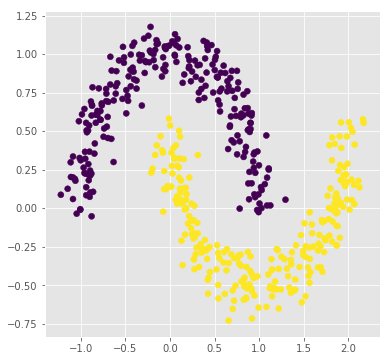

In [5]:
# visualize
plt.style.use('ggplot')
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(X[:,0], X[:,1], c=Y)
# ax.set_aspect('equal')
plt.show()

In [6]:
def identity(x):
    return(x)

In [7]:
# randomly get an integer to grab a datapoint
index = random.randint(0,N)
# index into our X array to get one datapoint
x = X[index,:]
# index into our Y array to get the true label of this datapoint
y = Y[index]

# naively draw weights and biases from a normal distribution
w = np.random.randn(2,1)
b = np.random.randn(1,)

# put our nonlinearity in here: this is just the identity function for now
sigma = identity

# our naive way of writing our equation above
y_hat = sigma(x[0]*w[0] + x[1]*w[1] + b)
# the vectorized way
y_hat_vectorized = sigma(np.dot(w.T, x) + b)

print('y_hat: ', y_hat)
print('y_hat_vectorized: ', y_hat_vectorized)

assert(np.linalg.norm(y_hat-y_hat_vectorized) < 1e-6)

y_hat:  [-0.13197408]
y_hat_vectorized:  [-0.13197408]


### Loss functions and the sigmoid nonlinearity
Okay, great. We have inputs $\mathbf{x}$, parameters $\mathbf{w}$ and $b$, and outputs $\hat{y}$. How do we know our predictions are any good? The last component is therefore to define a **loss function** $\mathcal{L}$ that defines how good or bad our predictions are. In the below example, we'll predict whether $\hat{y}$ should be 0 or 1, so we'll use the following loss function:

$$\mathcal{L} = - \big[y \log \hat{y} + (1-y)\log(1-\hat{y}) \big]$$

Why we use this function and not some other function is beyond the scope of this introduction. For a little help, notice that if our true label $y$ equals 1, then our loss is $-\log \hat{y}$ The bigger $\hat{y}$ is, the smaller our loss is. If our true label $y$ equals 0, then our loss is $-\log(1-\hat{y})$. 

A simple way to understand it is to look at the following image (code below):
![sigmoid plot](sigmoid.png)

Again, if $y=1$, then the smaller our estimate is, the bigger the loss. As $\lim_{\hat{y} \to 0} \mathcal{L}=\infty$ and if $\hat{y}=0$ then $\mathcal{L}=0$.

if $y=0$, then the bigger our estimate is, the bigger the loss. As $\lim_{\hat{y} \to 1} \mathcal{L}=\infty$ and if $\hat{y}=1$ then $\mathcal{L}=0$.

Notice another thing: for this loss function to work our $\hat{y}$ has to be between $[0,1]$. If $y=1$ and $\hat{y} > 1$, then our loss would be *negative*, and this means our loss can just keep going to negative infinity (not what we want). If $y=0$ and $\hat{y} > 1$, our loss is infinity, which is also not what we want.

This is a decent intuition for using the [**sigmoid nonlinearity**](https://en.wikipedia.org/wiki/Sigmoid_function): a function for squashing all values to the range between $[0,1]$.

$$sigmoid(x) = \frac{1}{1 + e^{-x}}$$

![bce loss function](bce_loss_function.png)

Let's implement these in numpy.

In [ ]:
# fig, axes = plt.subplots(1,3,figsize=(12,4))

# x = np.linspace(0,5,100)
# ax = axes[0]
# ax.plot(x,np.log(x))
# for point in [0.5, 1, 1.5]:
#     this_x, this_y = point, math.log(point)
#     this_string = '%.1f, %.4f'%(this_x, this_y)
#     ax.scatter(this_x,this_y, facecolor='r')
#     ax.text(this_x, this_y, this_string)
# ax.set_xlabel('x')
# ax.set_ylabel('log(x)')
# ax.set_title('Log function')

# ax = axes[1]
# x = np.linspace(0,1,100)
# ax.plot(x,-np.log(x))
# ax.set_ylabel('-log(x)')
# ax.set_xlabel('x')
# ax.set_title('Loss if y=1')

# ax = axes[2]
# ax.plot(x, -np.log(1-x))
# ax.set_xlabel('x')
# ax.set_ylabel('-log(1-x)')
# ax.set_title('Loss if y=0')

# plt.tight_layout()
# plt.show()

# x = np.linspace(-6,6,100)
# fig, ax = plt.subplots(1,1,figsize=(6,6))
# ax.plot(x,sigmoid(x))
# ax.set_ylabel('Sigmoid(x)')
# ax.set_xlabel('x')
# ax.set_title('The sigmoid nonlinearity')
# plt.show()

In [8]:
def loss_function(y_hat, y):
    loss = -( y*np.log(y_hat) + (1-y)*np.log(1-y_hat))
    return(loss)

def sigmoid(x):
    return(1/(1+np.exp(-x)))

In [9]:
sigma = sigmoid

y_hat = sigma( np.dot(w.T, x) + b )

loss = loss_function(y_hat,y)
print('y_hat: %.4f y:%d' %(y_hat,y))
print('Loss: %.4f' %loss)

y_hat: 0.4671 y:0
Loss: 0.6293


### Adding multiple neurons to our first layer
Okay, we've seen how to write a neural network that takes multiple input features and makes a single prediction. Instead of $\hat{y}$, let's call the output of our first equation our **activation** $a_{0}$ and call our weight vector $\mathbf{w}$ $\mathbf{w}_{0}$:
$$ a_{0} = \sigma(w_{0,0}x_{0} + w_{0,1}x_{1} + ... )$$

Let's add a new parameter vector $\mathbf{w}_{1}$ with a new set of weights:
$$ a_{1} = \sigma(w_{1,0}x_{0} + w_{1,1}x_{1} + ... )$$


In general, we can add as many neurons to a layer as we want and compute their activations as follows:
$$ a_{i} = \sigma(\mathbf{w_{i}}^\top \mathbf{x} + \mathbf{b}) $$

Now, it seems pretty dumb to make a for loop just to do a bunch of dot products at the same time. After all, that's what matrix multiplication is! Let's stack up all our $\mathbf{w_{i}}^\top$ into a big matrix, where the weight vectors are the rows, and we have the same number of units in the next layer as we have rows.
$$\mathbf{W} = \begin{bmatrix}  \rule[.5ex]{2em}{0.4pt} \mathbf{w}^\top_{0} \rule[.5ex]{2em}{0.4pt} \\ \rule[.5ex]{2em}{0.4pt} \mathbf{w}^\top_{1} \rule[.5ex]{2em}{0.4pt} \\ \rule[.5ex]{2em}{0.4pt} \mathbf{w}^\top_{2} \rule[.5ex]{2em}{0.4pt} \\ ... \end{bmatrix} $$

Now, our matrix $\mathbf{W}$ has $m$ rows (the number of output neurons) and $n$ columns, the number of inputs. Let's plug in the numbers from our 2-D example above, and say we're making a neural network with 10 neurons in the first layer. So $\mathbf{x}$ is $2x1$ and $\mathbf{W}$ is $10x2$:

$$ \mathbf{a} = \sigma(\mathbf{W}\cdot \mathbf{x} + \mathbf{b})$$

#### Figure 2: depiction of ANN with 2 input neurons, 10 output neurons
<img src="figure_2v3.png" alt="image depicting 10 neuron ann" style="width: 500px;"/>

Note that in this figure, rather than adding a bias vector to our activation vector, we're depicting it as another input $1$ multiplied by another weight $\mathbf{b}$. This is the same thing, depicted differently.

In [10]:
sigma = sigmoid

W = np.random.randn(10,2)
b = np.random.randn(10,)

index = random.randint(0,N)
# index into our X array to get one datapoint
x = X[index,:]

# the @ operator does matrix multiplication in numpy, same as np.dot()
a = sigma( W@x + b)

print('a: ', a.shape)
print(a)

a:  (10,)
[0.31505981 0.70661109 0.51700068 0.21388183 0.06692656 0.36106852
 0.11396276 0.11989417 0.9246407  0.87784405]


## Forward propagation: Making this a multi-layer neural network

Okay, we've seen how to write a neural network that takes multiple input features and makes one or more predictions. Aficionados will notice that this is just simple logistic regression. In the case of multiple units in our layer, we're just combining multiple logistic regression models.  How do we turn this from plain old boring *learning* model to <font size="4">***deep learning***</font>??

Simple. Let's stack them up!

Above, we saw that the output of one layer was $ \mathbf{a} = \sigma(\mathbf{W}\cdot \mathbf{x} + \mathbf{b})$. Let's add a new superscript $^{[\ell]}$ that denotes which layer our neurons are in. Notation from Andrew Ng's online course. Following the example from above, let's have a **1-hidden-layer neural network** with 2 inputs, 10 hidden units, and 1 output.

$$ \mathbf{a}^{[0]} = \sigma( \mathbf{W}^{[0]} \cdot \mathbf{x} + \mathbf{b}^{[0]} )$$
$$ \hat{y} = \sigma( \mathbf{W}^{[1]} \cdot \mathbf{a}^{[0]} + \mathbf{b}^{[1]} )$$

We can see the pattern: you multiply the previous layer's activation by the current layer's weight, and add the biases, then add the nonlinearity. In this case, we just treat our inputs $x$ as the zeroth activation, and our outputs $\hat{y}$ as our final activation. Importantly, as above, $\mathbf{W}^{[\ell]}$ has shape *outputs x inputs*.

Therefore, the general form is:
$$ \mathbf{a}^{[\ell]} = \sigma( \mathbf{W}^{[\ell]} \cdot \mathbf{a}^{[\ell-1]} + \mathbf{b}^{[\ell]} )$$

This process of using inputs, passing them through at least one hidden layer, and calculating our prediction is called ***forward propagation.***

#### Figure 3: ANN with 1 hidden layer
<img src="figure_3v1.png" alt="image depicting 1-hidden-layer ANN with 10 HU" style="width: 500px;"/>

In [11]:
sigma = sigmoid

W_0 = np.random.randn(10,2)
b_0 = np.random.randn(10,)

W_1 = np.random.randn(1,10)
b_1 = np.random.randn(1,)

index = random.randint(0,N)
# index into our X array to get one datapoint
x = X[index,:]
y = Y[index]

# the @ operator does matrix multiplication in numpy, same as np.dot()
a_0 = sigma( W_0@x + b_0)
a_1 = sigma( W_1@a_0 + b_1)

loss = loss_function(a_1, y)
print('a_0: ', a_0.shape)
print('a_1: ', a_1.shape)
print('Loss: %.4f' %loss)

a_0:  (10,)
a_1:  (1,)
Loss: 0.3081


In [15]:
class Network:
    def __init__(self,nonlinearity=sigmoid,neurons=10):
        W_0 = np.random.randn(neurons,2)
        b_0 = np.zeros(neurons,)

        W_1 = np.random.randn(1,neurons)
        b_1 = np.zeros(1,)
        
        self.nonlinearity = nonlinearity
        self.W_0 = W_0
        self.W_1 = W_1
        self.b_0 = b_0
        self.b_1 = b_1
        
    def forward(self,x):
        a_0 = sigma( self.W_0@x + self.b_0)
        a_1 = sigma( self.W_1@a_0 + self.b_1)
        return(a_1)

In [16]:
network = Network()

index = random.randint(0,N)
# index into our X array to get one datapoint
x = X[index,:]

y_hat = network.forward(x)
print(y_hat)

[0.78700141]


## Sidebar: why do you need nonlinearities?

Our network, in one line, is the following:
$$ \hat{y} = \sigma \big( \mathbf{W}^{[1]}\sigma( \mathbf{W}^{[0]} \cdot \mathbf{x} + \mathbf{b}^{[0]} ) +  \mathbf{b}^{[1]} \big)$$

What if you made $\sigma$ the identity function, so that there was no nonlinearities? We can simplify the notation a bit: 
$$ \hat{y} =  \mathbf{W}^{[1]}( \mathbf{W}^{[0]} \cdot \mathbf{x} + \mathbf{b}^{[0]} ) +  \mathbf{b}^{[1]}$$

Since this is just a linear function, we can use the associative and distributive properties of matrix multiplication to rewrite this out. For notation, in the superscript I'm going to put the dimensions of the matricies, so that we know we're not messing up.

$$ \hat{y} =  \mathbf{W}^{1x10}( \mathbf{W}^{10x2} \cdot \mathbf{x}^{2x1} + \mathbf{b}^{10x1} ) +  \mathbf{b}^{1,}$$
$$ \hat{y} =  \mathbf{W}^{1x10}\cdot \mathbf{W}^{10x2} \cdot \mathbf{x}^{2x1} + \mathbf{W}^{1x10}\cdot \mathbf{b}^{10x1} +  \mathbf{b}^{1,}$$
Now, let's just combine our matrices while leaving our inputs *x* the same:
$$ \hat{y} =  \mathbf{W}^{1x2}\cdot \mathbf{x}^{2x1} + \mathbf{b}^{1,} + \mathbf{b}^{1,}$$
$$ \hat{y} =  \mathbf{W}^{1x2}\cdot \mathbf{x}^{2x1} + \mathbf{b}^{1,}$$

Purely linear neural networks simply reduce to one linear layer! It doesn't matter how many layers we stack up. This model would only learn to predict lines or linear decision boundaries, which is not what we want at all. 

# Updating parameters: Backpropagation and gradient descent

### Gradient descent
Okay, we've learned how to make a simple one-hidden-layer neural network, and we've implemented *forward propagation*. We've also computed and implemented an appropriate *loss function* that defines how bad our predictions are. How do we use this loss function to update our parameters, $\mathbf{W}^{[0]}, \mathbf{W}^{[1]}, \mathbf{b}^{[0]}, \mathbf{b}^{[1]}$?

We will use **gradient descent**, the full explanation of which is beyond the scope of this introduction. It can be summed up in the following way. For all parameters $w$, repeat until convergence:
$$ w := w - \alpha \frac{\partial \mathcal{L}}{\partial w}$$

Here's a great visualization [from the internet](https://nikcheerla.github.io/deeplearningschool/). Gradients are just multi-dimensional slopes. We want to figure out how our loss changes as we change our parameters slightly, visualized here as 2 parameters, one weight and one bias. 
<img src="loss3d.gif" alt="https://nikcheerla.github.io/deeplearningschool/" style="width: 400px;"/>

As above, $\mathcal{L}$ is our loss, $w$ is our parameters, $\alpha$ is called the *learning rate*, and $\frac{\partial \mathcal{L}}{\partial w}$ is the derivative of our parameters with respect to our loss. If we had a method for computing gradients, we could compute the derivatives $\frac{\partial w_0}{\partial \mathcal{L}}$, $\frac{\partial w_1}{\partial \mathcal{L}}$, ... and so on, for each parameter in our network. However, modern neural networks can have *millions* of parameters. Computing gradients one at a time might take literally years! This brings us to the last essential ingredient of training neural networks: **backpropagation**, a method for computing derivatives in complex models. Using backpropagation, we can calculate the derivatives of *all* parameters w.r.t. our loss function at similar computational cost to the forward pass. 

### Backprop and computation graphs
Backpropagation is basically the chain rule (from calculus class) on steroids. To start, let's reframe an equation as a *computation graph*. [This blog post](https://colah.github.io/posts/2015-08-Backprop/) has a lot of nice graphics and ideas, so I'm going to copy them here.

Let's take the following expression:
$$ e = (a+b)*(b+1)  $$

We can redefine this as a graph, where each node is a computation, and inputs to a computation are edges.
<img src="computation_graph.png" alt="https://colah.github.io/posts/2015-08-Backprop/" style="width: 400px;"/>

Let's now take one possible derivative of this function, $\frac{\partial e}{\partial b}$. To make this concrete, let's set $a=2$ and $b=1$. First, let's multiply the expression out, then take the derivative. Apologies if there are errors in this part, it's been some years.

$$ e = a*b + a + b^2 + b $$
$$ \frac{\partial e}{\partial b} = a*1 + 0 + 2*b + 1 $$
When $a=2$ and $b=1$,
$$ \frac{\partial e}{\partial b} = 2*1 + 0 + 2*1 + 1 = 5$$
Now looking at a,
$$ \frac{\partial e}{\partial a} = 1+1 = 2$$

Imagine we wanted to compute the derivatives of *every* parameter in our neural network. To do so in the way I did above would be incredibly taxing--you'd have to write down the derivatives of each parameter $w$ w.r.t. our loss, and then compute them all sequentially. Instead, let's use our computation graph! We can compute the derivative of each node w.r.t. its inputs.
<img src="computation_graph_derivatives.png" alt="https://colah.github.io/posts/2015-08-Backprop/" style="width: 400px;"/>

Now we can use the chain rule! To calculate $\frac{\partial e}{\partial b} $, let's start at $e$ and work our way backwards to $b$. Recall that the chain rule states:

$$ h(x) = f(g(x))$$
$$ h'(x) = f'(g(x))g'(x)$$

Let's set $f(x) = c*d$ and $ g(x) = a + b$. Using the chain rule, we just multiply our two derivatives together: 
$$h'(x) = 2*1$$
Note that this is the same as our traditional solution above! $\frac{\partial e}{\partial b}$ is a bit more complicated, as there are multiple dependencies between $e$ and $b$. However, the short answer is that you multiply derivatives together in one path, while summing over paths. That gives: 

$$ \frac{\partial e}{\partial b} = 2*1 + 3*1 = 5$$

***Backpropagation is just the use of the chain rule to estimate the derivatives of all our parameters with respect to our loss function in one pass.*** This means we can calculate how our loss would change if we changed a parameter, at least locally to our current position in weight space. The amazing thing about backpropagation is that, by going backwards and computing derivatives in our graph *once*, we get the derivatives of *all* of our components w.r.t. the loss function! **Important note: this requires every element in our network to be differentiable.**

More info on backprop: 
* [Chris Nielsen's book](http://neuralnetworksanddeeplearning.com/chap2.html) and again, 
* [Chris Olah's blog](https://colah.github.io/posts/2015-08-Backprop/). In particular, here is a pretty good [proof](http://neuralnetworksanddeeplearning.com/chap2.html#proof_of_the_four_fundamental_equations_(optional)).
* [This video from 3blue1brown for an intuitive intro with amazing animations](https://www.youtube.com/watch?v=Ilg3gGewQ5U)
* [This follow up video that goes through the math](https://www.youtube.com/watch?v=tIeHLnjs5U8)

## Backprop in our simple neural network
#### Figure 4: computation graph for our ANN
<img src="figure_4.png" alt="computation graph for our simple nn" style="width: 600px;"/>


In [ ]:
# coding exercise implementing backpropagation is left as an exercise to the reader

### Putting it together: gradient descent and backprop

Taken together, the full process for training our neural network is as follows:

* Forward propagation (the "forward pass"): making our predictions
$$ \hat{y} = \sigma \big( \mathbf{W}^{[1]}\sigma( \mathbf{W}^{[0]} \cdot \mathbf{x} + \mathbf{b}^{[0]} ) +  \mathbf{b}^{[1]} \big)$$
* Computing our cost
$$\mathcal{L} = - \big[y \log \hat{y} + (1-y)\log(1-\hat{y}) \big]$$
* Backpropagation: computing how much our loss changes if we change each parameter slightly
$$ equations redacted $$
* Gradient descent: update our parameters in the opposite of the slope of the cost function
$$ w := w - \alpha \frac{\partial \mathcal{L}}{\partial w}$$

To see how this looks visualized, look at this image from [Jaewan Yun's GitHub:](https://github.com/Jaewan-Yun/optimizer-visualization)
<img src="optimization.gif" alt="https://github.com/Jaewan-Yun/optimizer-visualization" style="width: 400px;"/>

In [148]:
def sigmoid_grad(a):
    return(a*(1-a))

class Network:
    def __init__(self,nonlinearity=sigmoid,neurons=10):
        W_0 = np.random.randn(neurons,2)*.1
        b_0 = np.zeros((neurons,1), dtype=np.float32)

        W_1 = np.random.randn(1,neurons)*.1
        b_1 = np.zeros((1,1),dtype=np.float32)
        
        self.nonlinearity = nonlinearity
        
        parameters = {}
        parameters['W_0'] = W_0
        parameters['W_1'] = W_1
        parameters['b_0'] = b_0
        parameters['b_1'] = b_1
        
        self.parameters = parameters
        
    def forward(self,x):
        
        a_0 = sigma( self.parameters['W_0']@x + self.parameters['b_0'])
        self.a_0 = a_0
        
        a_1 = sigma( self.parameters['W_1']@a_0 + self.parameters['b_1'])
        self.a_1 = a_1
        return(a_1)
    
    def backward(self, y_hat, x, y):
        # import pdb
        # pdb.set_trace()
        # dl_da = (self.a_1 - y)/(self.a_1*(1-self.a_1))
        # da_dz = sigmoid_grad(self.a_1)
        # dz_dw = self.a_0
         #         layer1_error = delta_1.dot(self.parameters['W_1'])
        #         print('layer1_error: ',layer1_error.shape)
        #         delta_0 = layer1_error * sigmoid_grad(self.a_0).T
        #         print('delta_0: ',delta_0.shape)
        # delta is the "error" for the last layer
        # delta_1 = dl_da * da_dz
        
        loss_per_batch = np.mean(y_hat)
        
        output_error = (y_hat - y)/(y_hat*(1-y_hat))
        print('output: ', output_error.shape)
        delta_1 = output_error * sigmoid_grad(self.a_1)
        print('delta_1: ', delta_1.shape)
        
        dl_dw = delta_1.dot(self.a_0.T)
        print('dw1: ', dl_dw.shape)
        dl_db = delta_1
        print('db1: ', dl_db.shape)
        
        
       
        
        delta_0 = np.dot(delta_1, self.parameters['W_1']) * sigmoid_grad(self.a_0).T
        print('delta_0: ',delta_0.shape)
        
        dl_dw0 = np.dot(delta_0.T, x.T)# delta_0.dot(x.T)
        print('dw0: ', dl_dw0.shape)
        dl_db0 = delta_0.T
        
        gradients = {}
        gradients['W_1'] = dl_dw
        gradients['b_1'] = dl_db
        gradients['W_0'] = dl_dw0
        gradients['b_0'] = dl_db0
        return(gradients)

In [149]:
lr = 0.05
batch_size = 16

network = Network()


for i in range(100):
    index = np.random.randint(0,N, size=(batch_size,))
    # index into our X array to get one datapoint
    x = X[index,:].T
    y = Y[index]

    y_hat = network.forward(x)
    loss = loss_function(y_hat,y)
    gradients = network.backward(y_hat, x,y)
    
    print('step:%d: loss=%.4f' %(i,loss))
    for param in list(gradients.keys()):
        # print(network.parameters[param].shape, gradients[param].shape)
        network.parameters[param] -= lr*gradients[param]

output:  (1, 16)
delta_1:  (1, 16)
dw1:  (1, 10)
db1:  (1, 16)


ValueError: shapes (1,16) and (1,10) not aligned: 16 (dim 1) != 1 (dim 0)

# Training the same neural network we defined above, with Keras

In [ ]:
# we'll use this in a bit
def visualize_predictions(X, Y, predictions, model, grid_size=25):
    # make a grid 
    grid_lims = (np.floor(X.min()), np.ceil(X.max()))
    grid_vals = np.linspace(grid_lims[0], grid_lims[1],grid_size)
    xv, yv = np.meshgrid(grid_vals,grid_vals)
    # inputs to our network are flattened points on the grid
    inputs = np.vstack((xv.flatten(), yv.flatten())).T
    
    # use our model to make a prediction at every grid coordinate
    predictions = model.predict(inputs)
    # put back into an image-like shape
    score_map = predictions.reshape(xv.shape)
    
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    # use pcolor, which is like imshow but you can change the axis labels
    c = ax.pcolor(xv, yv, score_map, cmap='GnBu')
    # scatter our datapoints on top
    ax.scatter(X[:,0], X[:,1], c=Y)
    # add a colorbar
    fig.colorbar(c, ax=ax)
    plt.show()

In [ ]:
# let's use Keras to actually solve our problem!
from keras.models import Sequential
from keras.layers import Dense,Activation
import keras

model = Sequential([
    Dense(10, input_dim=2),
    Activation('sigmoid'),
    Dense(1),
    Activation('sigmoid')
])

opt = keras.optimizers.Adam(lr = 0.01)

# compile the model
model.compile(loss ='binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

# print out summary
model.summary()

In [ ]:
batch_size = 256
epochs = 100

history = model.fit(X,Y,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle = True, 
                    verbose = 1)

In [ ]:
visualize_predictions(X,Y, predictions, model, grid_size=100)

### Exercise: change the simple ANN above to try to minimize our loss on this dataset!





.

## Minibatch gradient descent: extending to multiple datapoints at once 


Okay, we now have a deep learning model that takes in two inputs, passes through a *hidden layer* with 10 neurons, and makes 1 prediction. We then calculate our gradients, and take a step in the opposite direction 

```python
for i in range(m):
    y_hat = sigma( W_1@sigma( W_0@x + b_0 ) + b_1 )
    loss = loss_function(y_hat, y)
    # update parameters
    gradients = backward(loss, ...)
    parameters = parameters - learning_rate * gradients
```

Gradient descent on one training example at a time is called *stochastic gradient descent*. This will be pretty slow, and our estimates of our gradients will be much noisier than if we could do *batch gradient descent*, wherein we make predictions and average our gradients for our entire dataset. For any difficult problem, you won't be able to fit our entire dataset into memory at once, so we have to use something in between. This is sometimes called *mini-batch gradient descent*, where we make predictions and update our parameters using some number of training examples $ 1 < n < N$.

Recall that our $\mathbf{x} \in  \mathbb{R}^{2x1}$ and our $\mathbf{W} \in \mathbb{R}^{10x2}$

$$\mathbf{W} = \begin{bmatrix}  \rule[.5ex]{2em}{0.4pt} \mathbf{w}^\top_{0} \rule[.5ex]{2em}{0.4pt} \\ \rule[.5ex]{2em}{0.4pt} \mathbf{w}^\top_{1} \rule[.5ex]{2em}{0.4pt} \\ \rule[.5ex]{2em}{0.4pt} \mathbf{w}^\top_{2} \rule[.5ex]{2em}{0.4pt} \\ ... \end{bmatrix} $$

Well, what if we just stacked up our $x$s, column-wise, next to each other into a new matrix $\mathbf{X}$?

$$\mathbf{X} = \begin{bmatrix}  \rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex} \\ \mathbf{x}_0 & \mathbf{x}_1 & \mathbf{x}_2... &  \\  \rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex} \end{bmatrix} $$

Now, our first layer equation is as follows:
$$ \mathbf{A}^{[0]} = \sigma( \mathbf{W}^{[0]} \cdot \mathbf{X} + \mathbf{b}^{[0]} )$$

Wait, all I did was capitalize the $x$ and $a$. That's because we've already defined our equations such that parallelizing over multiple examples is that easy! However, let's rewrite the equation with the matrix dimensions in the superscript again with batch size $bs$:

$$ \mathbf{A}^{10xbs} = \sigma( \mathbf{W}^{10x2} \cdot \mathbf{X}^{2xbs} + \mathbf{b}^{10x1} )$$

Note that our weight matrix didn't change at all, which is good! We don't want to change our parameters just because the batch size is changing. Note that the math doesn't work out with our bias, but we will add that to our activations with [broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html).

For completeness, note that our activations for each training example are now stacked up next to each other in columns:
$$\mathbf{A} = \begin{bmatrix}  \rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex} \\ \mathbf{a}_0 & \mathbf{a}_1 & \mathbf{a}_2... &  \\  \rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex} & \rule[-1ex]{0.5pt}{2.5ex} \end{bmatrix} $$

In [ ]:
sigma = sigmoid

W_0 = np.random.randn(10,2)
b_0 = np.random.randn(10,1)

W_1 = np.random.randn(1,10)
b_1 = np.random.randn(1,)

batch_size = 16

indices = np.random.randint(0,N, size=(batch_size,))
# index into our X array to get one datapoint
x = X[indices,:].T
y = Y[indices]

# the @ operator does matrix multiplication in numpy, same as np.dot()
a_0 = sigma( W_0@x + b_0)
a_1 = sigma( W_1@a_0 + b_1)

loss = loss_function(a_1, y)

print('Dimensions of our network with batch size %d' %batch_size)
print('a_0: ', a_0.shape)
print('a_1: ', a_1.shape)
print('Loss: ', loss.shape)

# Bonus: other common activation functions

In [ ]:
def relu(x):
    return(np.maximum(x,0))

def lrelu(x, leaky_slope=0.2):
    return(np.maximum(x,leaky_slope*x))

def tanh(x):
    return((np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x)) )

In [ ]:
x = np.linspace(-5,5)

fig, axes = plt.subplots(1,3,figsize=(12,4))
ax = axes[0]
ax.plot(x,relu(x))
ax.set_ylabel('activation')
ax.set_title('ReLU')

ax = axes[1]
ax.plot(x,lrelu(x))
ax.set_xlabel('input (z)')
ax.set_title('Leaky ReLU')

ax = axes[2]
ax.plot(x,tanh(x))
ax.set_title('Hyperbolic Tangent (tanh)')

plt.tight_layout()
plt.show()

# Gaining an intuition

We've learned so far what ANNs are, how to implement forward propagation, a bit about how backprop works, and how to define super simple models in Keras. A lot of what learning to use ANNs is a bit of intuition--is it better to use many layers or wide layers? Should we bother adding nonlinearities to our input features? Why can't you just use a linear model? What's the difference between relu and tanh and sigmoid and the swoop and .... etc.

There are very good principled answers to these questions, but to start out, head over to [this amazing website, the TensorFlow Playground](https://playground.tensorflow.org/), to try out some different network architectures, loss functions, activation functions, etc. Have fun!

Some exercises:
- [ ] What's the network with fewest neurons that can "solve" all classification tasks?
- [ ] What are good values for regularization that seem to work across tasks?
- [ ] How does the choice of activation function affect how the model solves the problem? And how fast?
- [ ] Can you make a learning rate schedule that minimizes the total number of epochs?

# TL;DR
* Neural networks are just stacks of linear models with nonlinearities in between them. 
* They are powerful function approximators
* We evaluate the error in our predictions with a defined **loss function**
* Each training iteration, we estimated the derivative of each parameter with respect to that loss function. This is called **backpropagation**. It requires that each component in our network is **differentiable.**
* To optimize our neural network, on every iteration we move the parameters a bit in the opposite direction of our gradients. Over time, this minimizes our loss.

The essential steps of training a neural network are as follows:
* Forward propagation: make a prediction with our current parameters and current minibatch of data
* Compute loss
* Compute our derivatives of parameters w.r.t. our loss (backpropagation)
* Update parameters